<a href="https://colab.research.google.com/github/FrancescoMonaco/BiasMedical/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

---
Base imports, definition of basic models and utility functions


In [1]:
#@title Libraries installation and base imports
!sudo pip install imbalanced-learn
!sudo pip install fairlearn
# Base import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Model import
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
# Support import
import seaborn as sns
import imblearn
import os
import requests
from io import StringIO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.7 MB/s eta 0:00:00


In [2]:
#@title Dataset load and base processing
# Load the dataset
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv"
df = pd.read_csv(StringIO(requests.get(url).text))

# Extract race feauture
race_mapping = {'white': 0, 'black': 1}
df['race'] = df['race'].map(race_mapping)

race = df['race']
# Substitute NaN values in order to use the data
df.fillna(0, inplace=True)
print("From now on index 0 will indicate white people, index 1 will indicate black people\n","Dataset distribution:\n", df['race'].value_counts().to_string(dtype=False), sep='')

From now on index 0 will indicate white people, index 1 will indicate black people
Dataset distribution:
0    43202
1     5582


In [3]:
#@title X, y extraction

X = df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t'], axis = 1)

# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']
y = df[['cost_t', 'gagne_sum_t', 'cost_avoidable_t']]

In [4]:
#@title Function for plotting num of comorbidities and spread of people at various risk levels
def plot_comorbidities(df, tit):
  """Function for plotting num of comorbidities and spread of people at various risk levels

  Parameters
  ------
  df: pd.DataFrame
    Dataframe where the data is stored
  tit: str
    String to use as title of the plot

  Returns
  ------
  void
  """
  
  columns_to_sum = ['alcohol_elixhauser_tm1','anemia_elixhauser_tm1',
              'arrhythmia_elixhauser_tm1','arthritis_elixhauser_tm1','bloodlossanemia_elixhauser_tm1','coagulopathy_elixhauser_tm1',
              'compdiabetes_elixhauser_tm1','depression_elixhauser_tm1','drugabuse_elixhauser_tm1','electrolytes_elixhauser_tm1',
              'hypertension_elixhauser_tm1','hypothyroid_elixhauser_tm1','liver_elixhauser_tm1','neurodegen_elixhauser_tm1','obesity_elixhauser_tm1',
              'paralysis_elixhauser_tm1','psychosis_elixhauser_tm1','pulmcirc_elixhauser_tm1','pvd_elixhauser_tm1','renal_elixhauser_tm1','uncompdiabetes_elixhauser_tm1',
              'valvulardz_elixhauser_tm1','wtloss_elixhauser_tm1','cerebrovasculardz_romano_tm1','chf_romano_tm1','dementia_romano_tm1','hemiplegia_romano_tm1',
              'hivaids_romano_tm1','metastatic_romano_tm1','myocardialinfarct_romano_tm1','pulmonarydz_romano_tm1','tumor_romano_tm1','ulcer_romano_tm1']

  sum_series = df.loc[:,columns_to_sum].sum(axis=1)
  print("max:",sum_series.max())

  # Create a new DataFrame 'sum_df' from the sum Series
  sum_df = pd.DataFrame({'Sum': sum_series})
  df_c = df.copy()
  df_c.loc[:,'sum'] = df.loc[:,'gagne_sum_tm1']

  # Scale the raw Risk scores to 0-100 
  scaler = MinMaxScaler(feature_range=(0, 100))


  df_plot1 = df_c.loc[df['race'] == 0]
  df_plot2 = df_c.loc[df['race'] == 1]

  scaler.fit(df_plot1['risk_score_t'].values.reshape(-1, 1))
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
  scaler.fit(df_plot2['risk_score_t'].values.reshape(-1, 1))
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)

 # Print the percentage at high risk
  print("*-------------------------------------*\n", \
        "Percentage of White People in the high risk section: ",\
        df_plot1[df_plot1.risk_score_t_scaled>75].shape[0]/(df_plot1[df_plot1.risk_score_t_scaled>75].shape[0]+df_plot2[df_plot2.risk_score_t_scaled>75].shape[0]),\
        "%\nPercentage of Black People in the high risk section: ",\
        df_plot2[df_plot2.risk_score_t_scaled>75].shape[0]/(df_plot1[df_plot1.risk_score_t_scaled>75].shape[0]+df_plot2[df_plot2.risk_score_t_scaled>75].shape[0]),\
        "%\n", "*-------------------------------------*\n",sep='')
  print("*-------------------------------------*\n", \
        "Num of White People in the high risk section: ",\
        df_plot1[df_plot1.risk_score_t_scaled>75].shape[0],\
        "\nNum of Black People in the high risk section: ",\
        df_plot2[df_plot2.risk_score_t_scaled>75].shape[0],\
        "\n", "*-------------------------------------*\n",sep='')

 # Create the plots
  counts_1 = df_plot1['risk_score_t_scaled'].value_counts() 
  counts_2 = df_plot2['risk_score_t_scaled'].value_counts()

  print("mean:",df_plot1['risk_score_t_scaled'].mean())

  if tit == 'New Label model' or tit == 'Decorrelate model': # A polynomial of degree 3 acts strangely in this context
    coefficients1 = np.polyfit(df_plot1['risk_score_t_scaled'], df_plot1['sum'], deg=4)
  else:
    coefficients1 = np.polyfit(df_plot1['risk_score_t_scaled'], df_plot1['sum'], deg=3)
  
  polynomial1 = np.poly1d(coefficients1)

  coefficients2 = np.polyfit(df_plot2['risk_score_t_scaled'], df_plot2['sum'], deg=3)
  polynomial2 = np.poly1d(coefficients2)

  x_count1 = counts_1.index.to_numpy()
  y_count1 = counts_1.values
  y_count1 = (y_count1-np.min(y_count1))/(np.max(y_count1)-np.min(y_count1))

  x_count2 = counts_2.index.to_numpy()
  y_count2 = counts_2.values
  y_count2 = (y_count2-np.min(y_count2))/(np.max(y_count2)-np.min(y_count2))

  #coeffsum1 = np.polyfit(x_count1, y_count1, deg=4)
  #coeffsum2 = np.polyfit(x_count2, y_count2, deg=4)

  #poly3 = np.poly1d(coeffsum1)
  #poly4 = np.poly1d(coeffsum2)

  # Generate x values for the curve
  x_vals = np.linspace(0, 100, num=100)
  x_vals2 = np.linspace(10,100, num= 90)

  # Evaluate the polynomial at x values to get y values for the curve
  y_vals1 = polynomial1(x_vals)
  y_vals2 = polynomial2(x_vals)
  y_vals3 = np.interp(x_vals2, x_count1, y_count1)#poly3(x_vals2)
  y_vals4 = np.interp(x_vals2, x_count2, y_count2)#poly4(x_vals2)

  # Create a plot
  plt.rcParams['figure.figsize'] = (12, 6)
  f, (ax1, ax2) = plt.subplots(1, 2)
    # Comorbidity plot
  ax1.plot(x_vals, y_vals1, label='White People')
  ax1.plot(x_vals, y_vals2, label='Black People')
  ax1.set_xlabel('risk_score_t')
  ax1.set_ylabel('comorbidities')
  ax1.set_title('Risk score vs Num of Comorbidities')
  ax1.legend()
  ax1.grid(True)
   # Number plot
  ax2.plot(x_vals2, y_vals3, label='White People')
  ax2.plot(x_vals2, y_vals4, label='Black People')
  ax2.set_xlabel('risk_score_t')
  ax2.set_ylabel('% of people in bin')
  ax2.set_title('% of people vs Risk Score')
  ax2.legend()
  ax2.grid(True)

  f.suptitle(tit, fontsize=16)


In [5]:
#@title Lasso model 
def train_lasso(X, y1, race, y2=None, y3=None):
  """Function to train a lasso regression

  Parameters
  ------
  X: pd.DataFrame
    features
  y1: pd.DataFrame
    target values
  race: pd.DataFrame
    sensible feature
  y2: pd.DataFrame, optional
    second target values
  y3: pd.DataFrame, optional
    third target values
    
  Returns
  ------
  pd.DataFrame
    Mean Squared Error of the training
  LassoCV
    Trained model
  """
  if y2 is None and y3 is None:
    X_train, X_val, y1_train, y1_val, race_train, race_val = train_test_split(X, y1, race, test_size=0.2, random_state=42)
    # Initialize LassoCV model
    lasso_model = LassoCV(cv=5) 

    # Train the LassoCV model
    lasso_model.fit(X_train, y1_train)
    y1_pred = lasso_model.predict(X_val)

    # Calculate mean squared error
    mse_1 = mean_squared_error(y1_val, y1_pred)
    # Create a DataFrame to store the MSE values
    mse_df = pd.DataFrame({'Target Variable': ['y1'],
                          'MSE': [mse_1]})

    # Filter rows based on 'race'
    race_black_mse_1 = mean_squared_error(y1_val[race_val == 1], y1_pred[race_val == 1])
    race_white_mse_1 = mean_squared_error(y1_val[race_val == 0], y1_pred[race_val == 0])

    mse_df = pd.DataFrame({'Target Variable': ['Cost_tot'],
                          'MSE': [mse_1],
                          'Race: Black MSE': [race_black_mse_1],
                          'Race: White MSE': [race_white_mse_1]})
    return mse_df, lasso_model

  else:
    X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val, race_train, race_val = train_test_split(X, y1, y2, y3, race, test_size=0.2, random_state=42)
    # Initialize LassoCV model
    lasso_model = LassoCV(cv=5) 

    # Train the LassoCV model for each target variable
    lasso_model.fit(X_train, y1_train)
    y1_pred = lasso_model.predict(X_val)

    lasso_model.fit(X_train, y2_train)
    y2_pred = lasso_model.predict(X_val)

    lasso_model.fit(X_train, y3_train)
    y3_pred = lasso_model.predict(X_val)

    # Calculate mean squared error for each target variable
    mse_1 = mean_squared_error(y1_val, y1_pred)
    mse_2 = mean_squared_error(y2_val, y2_pred)
    mse_3 = mean_squared_error(y3_val, y3_pred)
    # Create a DataFrame to store the MSE values
    mse_df = pd.DataFrame({'Target Variable': ['y1', 'y2', 'y3'],
                          'MSE': [mse_1, mse_2, mse_3]})

    # Filter rows based on 'race'
    race_black_mse_1 = mean_squared_error(y1_val[race_val == 1], y1_pred[race_val == 1])
    race_white_mse_1 = mean_squared_error(y1_val[race_val == 0], y1_pred[race_val == 0])

    race_black_mse_2 = mean_squared_error(y2_val[race_val == 1], y2_pred[race_val == 1])
    race_white_mse_2 = mean_squared_error(y2_val[race_val == 0], y2_pred[race_val == 0])

    race_black_mse_3 = mean_squared_error(y3_val[race_val == 1], y3_pred[race_val == 1])
    race_white_mse_3 = mean_squared_error(y3_val[race_val == 0], y3_pred[race_val == 0])

    mse_df = pd.DataFrame({'Target Variable': ['Cost_tot', 'Gagne_sum', 'Cost_avoid'],
                          'MSE': [mse_1, mse_2, mse_3],
                          'Race: Black MSE': [race_black_mse_1, race_black_mse_2, race_black_mse_3],
                          'Race: White MSE': [race_white_mse_1, race_white_mse_2, race_white_mse_3]})
    return mse_df, lasso_model

In [6]:
#@title Names of the main columns of the dataset
col_names = ['program_enrolled_t','bps_mean_t','ghba1c_mean_t','hct_mean_t','cre_mean_t','ldl_mean_t','dem_female','dem_age_band_18-24_tm1','dem_age_band_25-34_tm1',
             'dem_age_band_35-44_tm1','dem_age_band_45-54_tm1','dem_age_band_55-64_tm1','dem_age_band_65-74_tm1','dem_age_band_75+_tm1','alcohol_elixhauser_tm1','anemia_elixhauser_tm1',
             'arrhythmia_elixhauser_tm1','arthritis_elixhauser_tm1','bloodlossanemia_elixhauser_tm1','coagulopathy_elixhauser_tm1',
             'compdiabetes_elixhauser_tm1','depression_elixhauser_tm1','drugabuse_elixhauser_tm1','electrolytes_elixhauser_tm1',
             'hypertension_elixhauser_tm1','hypothyroid_elixhauser_tm1','liver_elixhauser_tm1','neurodegen_elixhauser_tm1','obesity_elixhauser_tm1',
             'paralysis_elixhauser_tm1','psychosis_elixhauser_tm1','pulmcirc_elixhauser_tm1','pvd_elixhauser_tm1','renal_elixhauser_tm1','uncompdiabetes_elixhauser_tm1',
             'valvulardz_elixhauser_tm1','wtloss_elixhauser_tm1','cerebrovasculardz_romano_tm1','chf_romano_tm1','dementia_romano_tm1','hemiplegia_romano_tm1',
             'hivaids_romano_tm1','metastatic_romano_tm1','myocardialinfarct_romano_tm1','pulmonarydz_romano_tm1','tumor_romano_tm1','ulcer_romano_tm1',
             'cost_dialysis_tm1','cost_emergency_tm1','cost_home_health_tm1','cost_ip_medical_tm1','cost_ip_surgical_tm1','cost_laboratory_tm1',
             'cost_op_primary_care_tm1','cost_op_specialists_tm1','cost_op_surgery_tm1','cost_other_tm1','cost_pharmacy_tm1','cost_physical_therapy_tm1',
             'cost_radiology_tm1','lasix_dose_count_tm1','lasix_min_daily_dose_tm1','lasix_mean_daily_dose_tm1','lasix_max_daily_dose_tm1','cre_tests_tm1',
             'crp_tests_tm1','esr_tests_tm1','ghba1c_tests_tm1','hct_tests_tm1','ldl_tests_tm1','nt_bnp_tests_tm1','sodium_tests_tm1','trig_tests_tm1','cre_min-low_tm1',
             'cre_min-high_tm1','cre_min-normal_tm1','cre_mean-low_tm1','cre_mean-high_tm1','cre_mean-normal_tm1','cre_max-low_tm1','cre_max-high_tm1','cre_max-normal_tm1',
             'crp_min-low_tm1','crp_min-high_tm1','crp_min-normal_tm1','crp_mean-low_tm1','crp_mean-high_tm1','crp_mean-normal_tm1','crp_max-low_tm1','crp_max-high_tm1',
             'crp_max-normal_tm1','esr_min-low_tm1','esr_min-high_tm1','esr_min-normal_tm1','esr_mean-low_tm1','esr_mean-high_tm1','esr_mean-normal_tm1','esr_max-low_tm1',
             'esr_max-high_tm1','esr_max-normal_tm1','ghba1c_min-low_tm1','ghba1c_min-high_tm1','ghba1c_min-normal_tm1','ghba1c_mean-low_tm1','ghba1c_mean-high_tm1',
             'ghba1c_mean-normal_tm1','ghba1c_max-low_tm1','ghba1c_max-high_tm1','ghba1c_max-normal_tm1','hct_min-low_tm1','hct_min-high_tm1','hct_min-normal_tm1',
             'hct_mean-low_tm1','hct_mean-high_tm1','hct_mean-normal_tm1','hct_max-low_tm1','hct_max-high_tm1','hct_max-normal_tm1','ldl_min-low_tm1','ldl_min-high_tm1',
             'ldl_min-normal_tm1','ldl-mean-low_tm1','ldl-mean-high_tm1','ldl-mean-normal_tm1','ldl_max-low_tm1','ldl_max-high_tm1','ldl_max-normal_tm1',
             'nt_bnp_min-low_tm1','nt_bnp_min-high_tm1','nt_bnp_min-normal_tm1','nt_bnp_mean-low_tm1','nt_bnp_mean-high_tm1','nt_bnp_mean-normal_tm1',
             'nt_bnp_max-low_tm1','nt_bnp_max-high_tm1','nt_bnp_max-normal_tm1','sodium_min-low_tm1','sodium_min-high_tm1','sodium_min-normal_tm1',
             'sodium_mean-low_tm1','sodium_mean-high_tm1','sodium_mean-normal_tm1','sodium_max-low_tm1','sodium_max-high_tm1','sodium_max-normal_tm1',
             'trig_min-low_tm1','trig_min-high_tm1','trig_min-normal_tm1',
             'trig_mean-low_tm1','trig_mean-high_tm1','trig_mean-normal_tm1','trig_max-low_tm1','trig_max-high_tm1','trig_max-normal_tm1','gagne_sum_tm1']

#Base Model

---
The base model mimics the one used in common health applications produced by insurance companies in the USA to manage health in populations.
The model is based on the one showed in Obermeyer, Z., Powers, B., Vogeli, C., Mullainathan, S., *Dissecting racial bias in an algorithm used to manage the health of populations*, Science 366, https://escholarship.org/content/qt6h92v832/qt6h92v832.pdf, pp.447-453, 2019.


In [7]:
#@title Training
mse_df, _ = train_lasso(X, y1, race, y2, y3)

# Print
print(mse_df.to_string(index=False))

Target Variable          MSE  Race: Black MSE  Race: White MSE
       Cost_tot 2.656967e+08     4.160072e+08     2.459493e+08
      Gagne_sum 2.784019e+00     4.464028e+00     2.563304e+00
     Cost_avoid 1.386470e+08     1.617675e+08     1.356095e+08


max: 18
*-------------------------------------*
Percentage of White People in the high risk section: 0.8125%
Percentage of Black People in the high risk section: 0.1875%
*-------------------------------------*

*-------------------------------------*
Num of White People in the high risk section: 13
Num of Black People in the high risk section: 3
*-------------------------------------*

mean: 3.7695477061247162


<ipython-input-4-df564a953dd6>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
<ipython-input-4-df564a953dd6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)


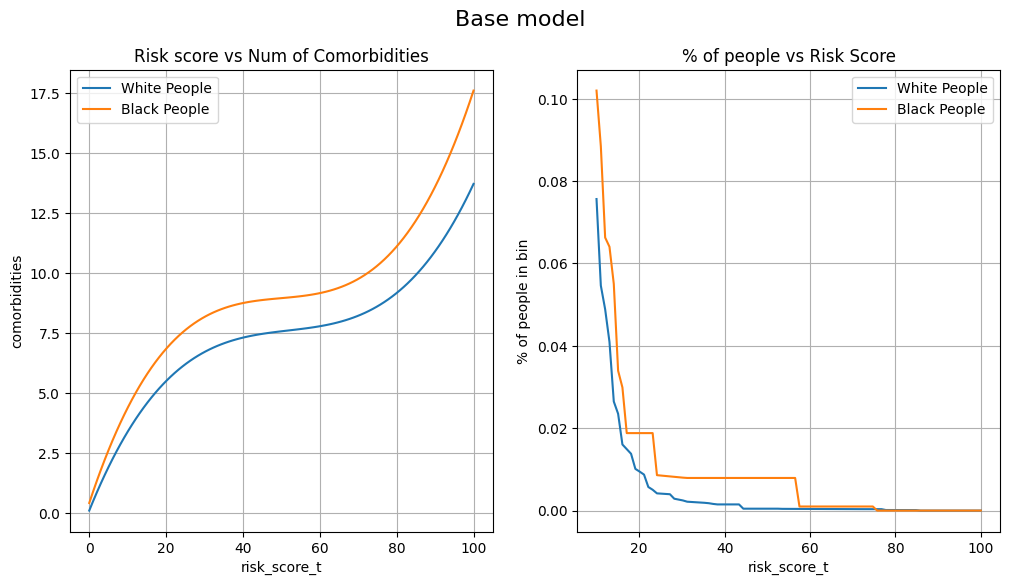

In [8]:
plot_comorbidities(df, 'Base model')

#Correlation Remover

---
The following approach consists in using a library specilized in fairness to pre-process the data and remove the correlation between the sensitive features and the others.

Bird, S., Dudík, M., Edgar, R., Horn, B., Lutz, R., Milan, V., Sameki, M., Wallach, H., Walker, K., *Fairlearn: A toolkit for assessing and improving fairness in AI*, Techreport MSR-TR-2020-32, Microsoft, https://www.microsoft.com/en-us/research/publication/fairlearn-a-toolkit-for-assessing-and-improving-fairness-in-ai/, 2020.


In [9]:
#@title Clean the data
# Load the dataset
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv"
df = pd.read_csv(StringIO(requests.get(url).text))

# Extract race feauture
race_mapping = {'white': 0, 'black': 1}
df['race'] = df['race'].map(race_mapping)

race = df['race']
# Substitute NaN values in order to use the data
df.fillna(0, inplace=True)


X = df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t'], axis = 1)

# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']
y = df[['cost_t', 'gagne_sum_t', 'cost_avoidable_t']]

In [10]:
#@title Util function to produce heatmaps
# As shown on an example on FairLearn
def plot_heatmap(df, title, axis, n = 0):
  """Function for plotting the correlation between features

  Parameters
  ------
  df: pd.DataFrame
    Dataframe where the data is stored
  title: str
    String to use as title of the plot
  axis: plt.axis
    Axis where to plot the result
  n: int, optional (default is 0)
    number of the plot (to manage where the y labels 
                  and the colorbar should be printed)

  Returns
  ------
  void
  """
  
  data = df[['cost_t', 'cost_op_surgery_tm1','cost_other_tm1',
             'cost_pharmacy_tm1','cost_physical_therapy_tm1',
             'cost_dialysis_tm1','cost_emergency_tm1','cost_home_health_tm1',
             'risk_score_t']]
  if n == 2:
    dataplot = sns.heatmap(data.corr(), cmap='cividis', ax = axis, cbar = False, yticklabels = False)
    #dataplot.set_ylabel('Column Names')
    dataplot.set_xlabel('')
    #dataplot.set_yticklabels(data.columns, rotation=0)
    axis.set_title(title)
  elif n == 3:
    dataplot = sns.heatmap(data.corr(), cmap='cividis', ax=axis)
    dataplot.set_ylabel('')
    dataplot.set_xlabel('')
    dataplot.set_yticks([])
    axis.set_title(title)
  else: 
    dataplot = sns.heatmap(data.corr(), cmap='cividis', ax = axis, cbar = False)
    dataplot.set_xlabel('')
    axis.set_title(title)
  

In [11]:
#@title Model
from fairlearn.preprocessing import CorrelationRemover

# Retrieve all the data
var = ['risk_score_t', 'race', 'cost_t' , 'gagne_sum_t', 'cost_avoidable_t', 'cost_dialysis_tm1',
                 'cost_emergency_tm1','cost_home_health_tm1',
                 'cost_ip_medical_tm1','cost_ip_surgical_tm1','cost_laboratory_tm1',
             'cost_op_primary_care_tm1','cost_op_specialists_tm1','cost_op_surgery_tm1',
             'cost_other_tm1','cost_pharmacy_tm1','cost_physical_therapy_tm1','cost_radiology_tm1']

var2 = ['program_enrolled_t','bps_mean_t','ghba1c_mean_t','hct_mean_t','cre_mean_t','ldl_mean_t','dem_female','dem_age_band_18-24_tm1','dem_age_band_25-34_tm1',
             'dem_age_band_35-44_tm1','dem_age_band_45-54_tm1','dem_age_band_55-64_tm1','dem_age_band_65-74_tm1','dem_age_band_75+_tm1','alcohol_elixhauser_tm1','anemia_elixhauser_tm1',
             'arrhythmia_elixhauser_tm1','arthritis_elixhauser_tm1','bloodlossanemia_elixhauser_tm1','coagulopathy_elixhauser_tm1',
             'compdiabetes_elixhauser_tm1','depression_elixhauser_tm1','drugabuse_elixhauser_tm1','electrolytes_elixhauser_tm1',
             'hypertension_elixhauser_tm1','hypothyroid_elixhauser_tm1','liver_elixhauser_tm1','neurodegen_elixhauser_tm1','obesity_elixhauser_tm1',
             'paralysis_elixhauser_tm1','psychosis_elixhauser_tm1','pulmcirc_elixhauser_tm1','pvd_elixhauser_tm1','renal_elixhauser_tm1','uncompdiabetes_elixhauser_tm1',
             'valvulardz_elixhauser_tm1','wtloss_elixhauser_tm1','cerebrovasculardz_romano_tm1','chf_romano_tm1','dementia_romano_tm1','hemiplegia_romano_tm1',
             'hivaids_romano_tm1','metastatic_romano_tm1','myocardialinfarct_romano_tm1','pulmonarydz_romano_tm1','tumor_romano_tm1','ulcer_romano_tm1',
             'lasix_dose_count_tm1','lasix_min_daily_dose_tm1','lasix_mean_daily_dose_tm1','lasix_max_daily_dose_tm1','cre_tests_tm1',
             'crp_tests_tm1','esr_tests_tm1','ghba1c_tests_tm1','hct_tests_tm1','ldl_tests_tm1','nt_bnp_tests_tm1','sodium_tests_tm1','trig_tests_tm1','cre_min-low_tm1',
             'cre_min-high_tm1','cre_min-normal_tm1','cre_mean-low_tm1','cre_mean-high_tm1','cre_mean-normal_tm1','cre_max-low_tm1','cre_max-high_tm1','cre_max-normal_tm1',
             'crp_min-low_tm1','crp_min-high_tm1','crp_min-normal_tm1','crp_mean-low_tm1','crp_mean-high_tm1','crp_mean-normal_tm1','crp_max-low_tm1','crp_max-high_tm1',
             'crp_max-normal_tm1','esr_min-low_tm1','esr_min-high_tm1','esr_min-normal_tm1','esr_mean-low_tm1','esr_mean-high_tm1','esr_mean-normal_tm1','esr_max-low_tm1',
             'esr_max-high_tm1','esr_max-normal_tm1','ghba1c_min-low_tm1','ghba1c_min-high_tm1','ghba1c_min-normal_tm1','ghba1c_mean-low_tm1','ghba1c_mean-high_tm1',
             'ghba1c_mean-normal_tm1','ghba1c_max-low_tm1','ghba1c_max-high_tm1','ghba1c_max-normal_tm1','hct_min-low_tm1','hct_min-high_tm1','hct_min-normal_tm1',
             'hct_mean-low_tm1','hct_mean-high_tm1','hct_mean-normal_tm1','hct_max-low_tm1','hct_max-high_tm1','hct_max-normal_tm1','ldl_min-low_tm1','ldl_min-high_tm1',
             'ldl_min-normal_tm1','ldl-mean-low_tm1','ldl-mean-high_tm1','ldl-mean-normal_tm1','ldl_max-low_tm1','ldl_max-high_tm1','ldl_max-normal_tm1',
             'nt_bnp_min-low_tm1','nt_bnp_min-high_tm1','nt_bnp_min-normal_tm1','nt_bnp_mean-low_tm1','nt_bnp_mean-high_tm1','nt_bnp_mean-normal_tm1',
             'nt_bnp_max-low_tm1','nt_bnp_max-high_tm1','nt_bnp_max-normal_tm1','sodium_min-low_tm1','sodium_min-high_tm1','sodium_min-normal_tm1',
             'sodium_mean-low_tm1','sodium_mean-high_tm1','sodium_mean-normal_tm1','sodium_max-low_tm1','sodium_max-high_tm1','sodium_max-normal_tm1',
             'trig_min-low_tm1','trig_min-high_tm1','trig_min-normal_tm1',
             'trig_mean-low_tm1','trig_mean-high_tm1','trig_mean-normal_tm1','trig_max-low_tm1','trig_max-high_tm1','trig_max-normal_tm1','gagne_sum_tm1']
X_toProcess = df[var]

# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']

# No alpha version
cr = CorrelationRemover(sensitive_feature_ids=["race",'risk_score_t', 'cost_t'])
X_cr = cr.fit_transform(X_toProcess)
X_cr = pd.DataFrame(X_cr, columns=var[3:])
X_cr["race"] = X["race"]
X_cr["risk_score_t"] = X_toProcess["risk_score_t"]
X_cr['cost_t'] = X_toProcess['cost_t']
X_cr = pd.concat([X_cr, df[var2]], axis=1)

mse_df, model_correlation = train_lasso(X_cr, y1, race, y2, y3)
# Print
print("Without alpha\n", mse_df.to_string(index=False), sep='')

# Alpha version
cr_alpha = CorrelationRemover(sensitive_feature_ids=['race','risk_score_t'], alpha=0.75)
X_toProcess = df[var]
X_cr_alpha = cr_alpha.fit_transform(X_toProcess)
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=var[2:])
X_cr_alpha["race"] = X["race"]
X_cr_alpha["risk_score_t"] = X_toProcess["risk_score_t"]
X_cr_alpha = pd.concat([X_cr_alpha, df[var2]], axis=1)
mse_df, _ = train_lasso(X_cr_alpha, y1, race, y2, y3)

# Print
print("With alpha\n", mse_df.to_string(index=False), sep='')

Without alpha
Target Variable          MSE  Race: Black MSE  Race: White MSE
       Cost_tot 3.233641e+02     6.350033e+02     2.824217e+02
      Gagne_sum 3.099202e+00     4.941010e+00     2.857230e+00
     Cost_avoid 1.131832e+06     1.993187e+06     1.018669e+06
With alpha
Target Variable          MSE  Race: Black MSE  Race: White MSE
       Cost_tot 3.395141e+07     7.556353e+07     2.848451e+07
      Gagne_sum 3.266279e+00     5.497961e+00     2.973086e+00
     Cost_avoid 6.484305e+06     1.428402e+07     5.459597e+06


In [12]:
#@title Calculate risk
y_r = X_cr['risk_score_t']

_, model_r = train_lasso(X_cr, y_r, race)

risk = model_r.predict(X_cr)

X_cr['risk_score_t'] = risk

max: 18
*-------------------------------------*
Percentage of White People in the high risk section: 0.6428571428571429%
Percentage of Black People in the high risk section: 0.35714285714285715%
*-------------------------------------*

*-------------------------------------*
Num of White People in the high risk section: 9
Num of Black People in the high risk section: 5
*-------------------------------------*

mean: 0.9648395907596871


<ipython-input-4-df564a953dd6>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
<ipython-input-4-df564a953dd6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)


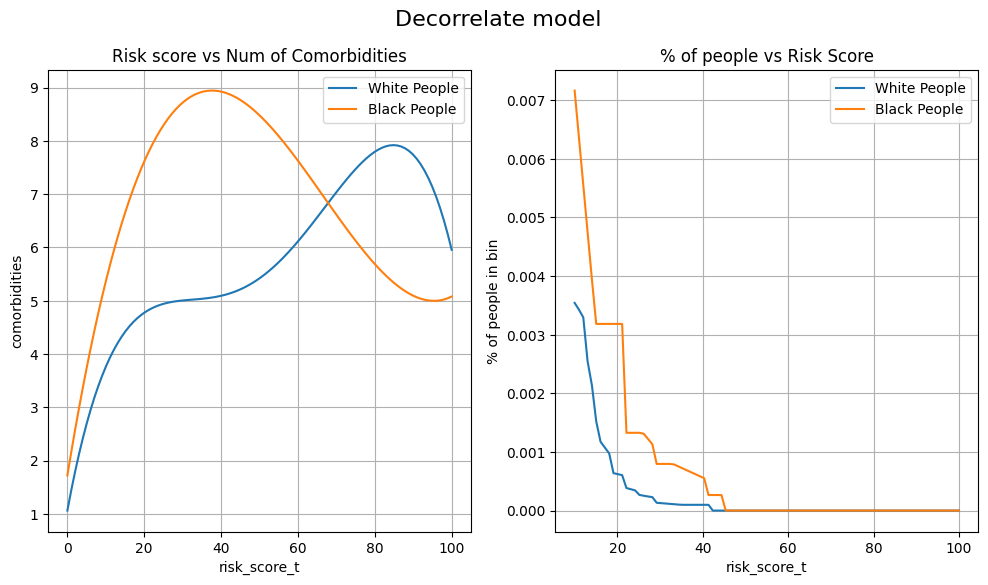

In [13]:
#@title Plot the comorbidities curves
plot_comorbidities(X_cr, 'Decorrelate model')

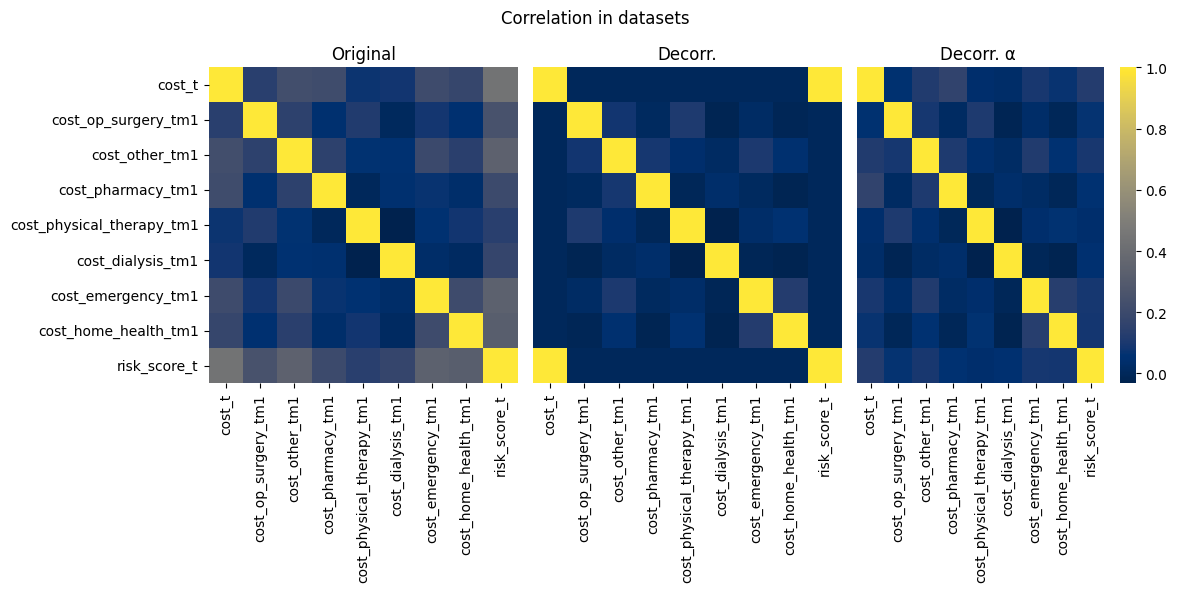

In [14]:
#@title Heatmaps
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.suptitle("Correlation in datasets")
#ax1.get_shared_y_axes().join(ax2,ax3)
plot_heatmap(X_toProcess, "Original", ax1, n = 1)
plot_heatmap(X_cr, "Decorr.", ax2, n = 2)
plot_heatmap(X_cr_alpha, "Decorr. \u03B1 ", ax3, 3)
plt.tight_layout()
plt.show()

In [15]:
del var, var2, X_cr, X_cr_alpha, X_toProcess, cr, cr_alpha, model_r, risk

#Augmented Model

---
The approach consists in creating synthetic observations for the minority class, with the goal of giving the algorithm the opportunity of learning the underlining patterns, as showed in Fu, R., Huang, Y., Singh, P. V., *AI and Algorithmic Bias: Source, Detection, Mitigation and Implications*, http://dx.doi.org/10.2139/ssrn.3681517, 2020.


In [16]:
#@title Clean the data
# Load the dataset
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv"
df = pd.read_csv(StringIO(requests.get(url).text))

# Extract race feauture
race_mapping = {'white': 0, 'black': 1}
df['race'] = df['race'].map(race_mapping)

race = df['race']
# Substitute NaN values in order to use the data
df.fillna(0, inplace=True)


X = df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t'], axis = 1)

# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']
y = df[['cost_t', 'gagne_sum_t', 'cost_avoidable_t']]

In [17]:
#@title Model
from imblearn.over_sampling import ADASYN
'''
ADASYN showed better results in comparison to SMOTE, due to the fact that the
algorithm takes into account the local distribution of the samples
'''

# Identify the minority class in the 'race' column
values = df['race'].value_counts().to_string(dtype = False)
print("Before oversampling:\n", values, sep='')
# Instantiate OverSampler
oversampler = ADASYN(random_state=42, sampling_strategy = 'auto')

# Generate synthetic samples
df_augmented, race_aug = oversampler.fit_resample(df.drop('race', axis=1), df['race'])

values = race_aug.value_counts().to_string(dtype = False)
print("After oversampling:\n", values, sep='')
# Extract the data for training
y1_augmented =  df_augmented['cost_t']
X_aug = df_augmented.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t'], axis = 1)

# Train
mse_df, model_aug = train_lasso(X_aug, y1_augmented, race_aug)
X_aug['race'] = race_aug
print(mse_df.to_string(index=False))

Before oversampling:
0    43202
1     5582
After oversampling:
1    43570
0    43202
Target Variable          MSE  Race: Black MSE  Race: White MSE
       Cost_tot 2.714576e+08     3.465122e+08     1.953666e+08


max: 18
*-------------------------------------*
Percentage of White People in the high risk section: 0.6666666666666666%
Percentage of Black People in the high risk section: 0.3333333333333333

<ipython-input-4-df564a953dd6>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
<ipython-input-4-df564a953dd6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)


%
*-------------------------------------*

*-------------------------------------*
Num of White People in the high risk section: 6
Num of Black People in the high risk section: 3
*-------------------------------------*

mean: 2.047451506874682


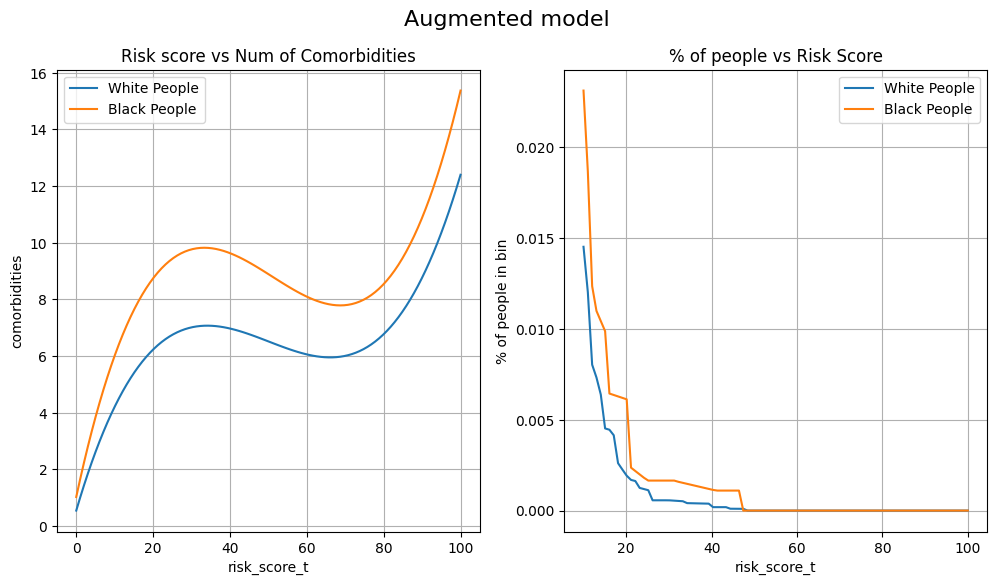

In [18]:
#@title Plot the comorbidities curves

y1_r = model_aug.predict(df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t','race'], axis = 1))
y1_r = np.reshape(y1_r, (-1,1))
risk_reg = LinearRegression().fit(y1_r, X['risk_score_t'])
risk = risk_reg.predict(y1_r)

X['risk_score_t'] = risk

plot_comorbidities(X, 'Augmented model')

In [19]:
del risk_reg, X_aug, y1_r, oversampler, race_aug, y1_augmented

# Model on a new label

---

The original work suggests working on a new label (cost_avoidable instead of cost_tot) but they keep producing the risk score as a function of the label used, the next experiment tries to use some basic pre-processing on the data and works with a model that retrievies the risk score directly.

**Risk score equation**
$$
R_i = \left( \sum_{k\in \text{ comorbidities-i}} mortalityRate(k) \right) + \left( \sum_{j\in \text{ biomarkers-i}} OutOfBounds(j) \right) 
+ \left( \sum_{v\in \text{ costs-i}} \frac{v}{10}\right) + AgePenalty(i)
$$

**Biomarkers equation**
$$
OutOfBounds(j) = \begin{cases} 0 \text{ if } lowerBound \leq j\leq upperBound \\
2 \text{ else}
\end{cases}
$$
**Age Penalty equation**
$$
AgePenalty(i) = \begin{cases} 0 \text{ if } (i.age)\leq 65 \\
5 \text{ else} 
\end{cases}
$$

Mortality rates taken from:

*   https://www.who.int/data/gho/indicator-metadata-registry
*   https://pubmed.ncbi.nlm.nih.gov/21828943/
*   https://ourworldindata.org/grapher/infectious-disease-death-rates



In [20]:
#@title Clean the data
# Load the dataset
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv"
df = pd.read_csv(StringIO(requests.get(url).text))

# Extract race feauture
race_mapping = {'white': 0, 'black': 1}
df['race'] = df['race'].map(race_mapping)

race = df['race']
# Substitute NaN values in order to use the data
df.fillna(0, inplace=True)


X = df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t','risk_score_t'], axis = 1)
# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']
y = df[['cost_t', 'gagne_sum_t', 'cost_avoidable_t']]
y_r = df['risk_score_t']

In [21]:
#@title Array of basic data
# Multiplicators
BIO_MULTIPLICATOR = 2
GAGNE_MULTIPLICATOR = 5
COST_MULTIPLICATOR = 1/10

columns = ['alcohol_elixhauser_tm1','anemia_elixhauser_tm1',
             'arrhythmia_elixhauser_tm1','arthritis_elixhauser_tm1','bloodlossanemia_elixhauser_tm1','coagulopathy_elixhauser_tm1',
             'compdiabetes_elixhauser_tm1','depression_elixhauser_tm1','drugabuse_elixhauser_tm1','electrolytes_elixhauser_tm1',
             'hypertension_elixhauser_tm1','hypothyroid_elixhauser_tm1','liver_elixhauser_tm1','neurodegen_elixhauser_tm1','obesity_elixhauser_tm1',
             'paralysis_elixhauser_tm1','psychosis_elixhauser_tm1','pulmcirc_elixhauser_tm1','pvd_elixhauser_tm1','renal_elixhauser_tm1','uncompdiabetes_elixhauser_tm1',
             'valvulardz_elixhauser_tm1','wtloss_elixhauser_tm1','cerebrovasculardz_romano_tm1','chf_romano_tm1','dementia_romano_tm1','hemiplegia_romano_tm1',
             'hivaids_romano_tm1','metastatic_romano_tm1','myocardialinfarct_romano_tm1','pulmonarydz_romano_tm1','tumor_romano_tm1','ulcer_romano_tm1']
hospitalization_percentages = {
    'alcohol_elixhauser_tm1': 10,       #
    'anemia_elixhauser_tm1': 10,       #
    'arrhythmia_elixhauser_tm1': 10,     #
    'arthritis_elixhauser_tm1': 10,    #
    'bloodlossanemia_elixhauser_tm1': 10,#
    'coagulopathy_elixhauser_tm1': 10,#
    'compdiabetes_elixhauser_tm1': 10,  #
    'depression_elixhauser_tm1': 4,   
    'drugabuse_elixhauser_tm1': 10,     #
    'electrolytes_elixhauser_tm1': 10, # 
    'hypertension_elixhauser_tm1': 13,  
    'hypothyroid_elixhauser_tm1': 10,   #
    'liver_elixhauser_tm1': 10,        #
    'neurodegen_elixhauser_tm1': 10,     #
    'obesity_elixhauser_tm1': 10, #
    'paralysis_elixhauser_tm1': 10,#
    'psychosis_elixhauser_tm1': 10,#
    'pulmcirc_elixhauser_tm1': 20,
    'pvd_elixhauser_tm1': 10,#
    'renal_elixhauser_tm1': 15,
    'uncompdiabetes_elixhauser_tm1': 8,
    'valvulardz_elixhauser_tm1': 10,     # 
    'wtloss_elixhauser_tm1': 10,#
    'cerebrovasculardz_romano_tm1': 10, #
    'chf_romano_tm1': 10,#
    'dementia_romano_tm1': 10,           #
    'hemiplegia_romano_tm1': 24,        
    'hivaids_romano_tm1': 10,          #
    'metastatic_romano_tm1': 10,       #
    'myocardialinfarct_romano_tm1': 34, 
    'pulmonarydz_romano_tm1': 10,      #
    'tumor_romano_tm1': 14,            
    'ulcer_romano_tm1': 15             
}

hospitalization_percentages_array = [hospitalization_percentages[col] for col in columns]

bio_columns = ['cre_min-low_tm1',
             'cre_min-high_tm1','cre_mean-low_tm1','cre_mean-high_tm1','cre_max-low_tm1','cre_max-high_tm1',
             'crp_min-low_tm1','crp_min-high_tm1','crp_mean-low_tm1','crp_mean-high_tm1','crp_max-low_tm1','crp_max-high_tm1',
             'esr_min-low_tm1','esr_min-high_tm1','esr_mean-low_tm1','esr_mean-high_tm1','esr_max-low_tm1',
             'esr_max-high_tm1','ghba1c_min-low_tm1','ghba1c_min-high_tm1','ghba1c_min-normal_tm1','ghba1c_mean-low_tm1','ghba1c_mean-high_tm1',
             'ghba1c_max-low_tm1','ghba1c_max-high_tm1','hct_min-low_tm1','hct_min-high_tm1',
             'hct_mean-low_tm1','hct_mean-high_tm1','hct_max-low_tm1','hct_max-high_tm1','ldl_min-low_tm1','ldl_min-high_tm1',
             'ldl-mean-low_tm1','ldl-mean-high_tm1','ldl_max-low_tm1','ldl_max-high_tm1',
             'nt_bnp_min-low_tm1','nt_bnp_min-high_tm1','nt_bnp_mean-low_tm1','nt_bnp_mean-high_tm1',
             'nt_bnp_max-low_tm1','nt_bnp_max-high_tm1','nt_bnp_max-normal_tm1','sodium_min-low_tm1','sodium_min-high_tm1',
             'sodium_mean-low_tm1','sodium_mean-high_tm1','sodium_max-low_tm1','sodium_max-high_tm1',
             'trig_min-low_tm1','trig_min-high_tm1','trig_min-normal_tm1',
             'trig_mean-low_tm1','trig_mean-high_tm1','trig_max-low_tm1','trig_max-high_tm1']

cost_columns = ['cost_dialysis_tm1','cost_emergency_tm1','cost_home_health_tm1','cost_ip_medical_tm1','cost_ip_surgical_tm1','cost_laboratory_tm1',
             'cost_op_primary_care_tm1','cost_op_specialists_tm1','cost_op_surgery_tm1','cost_other_tm1','cost_pharmacy_tm1','cost_physical_therapy_tm1',
             'cost_radiology_tm1']

In [22]:
#@title Create new risk score
df_y = df[columns]#.astype(float)
# Mortality rate proportional term
df_y = df_y * hospitalization_percentages_array
# Penalization for biomarkers
df_bio = df[bio_columns].multiply(BIO_MULTIPLICATOR)
# Penalization for multiple comorbidities
df_num = df['gagne_sum_tm1'].multiply(GAGNE_MULTIPLICATOR)
# Penalization for age 
df_age = df[['dem_age_band_75+_tm1', 'dem_age_band_65-74_tm1']].multiply(GAGNE_MULTIPLICATOR)
# Penalization for high costs
df_cost = df[cost_columns].multiply(COST_MULTIPLICATOR)

df_y = pd.concat([df_y, df_bio, df_num, df_age, df_cost], axis=1)
df_y_sum = df_y.sum(axis=1)

In [23]:
#@title Train the model
mse_df, model_r = train_lasso(X, df_y_sum, race)

risk = model_r.predict(X)
# Print
print(mse_df.to_string(index=False))

X['risk_score_t'] = risk

Target Variable         MSE  Race: Black MSE  Race: White MSE
       Cost_tot 1341.219418      2406.917426      1201.210623


max: 18
*-------------------------------------*
Percentage of White People in the high risk section: 0.6923076923076923%
Percentage of Black People in the high risk section: 0.3076923076923077%
*-------------------------------------*

*-------------------------------------*
Num of White People in the high risk section: 9
Num of Black People in the high risk section: 4
*-------------------------------------*

mean: 1.5370584695153002


<ipython-input-4-df564a953dd6>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
<ipython-input-4-df564a953dd6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)


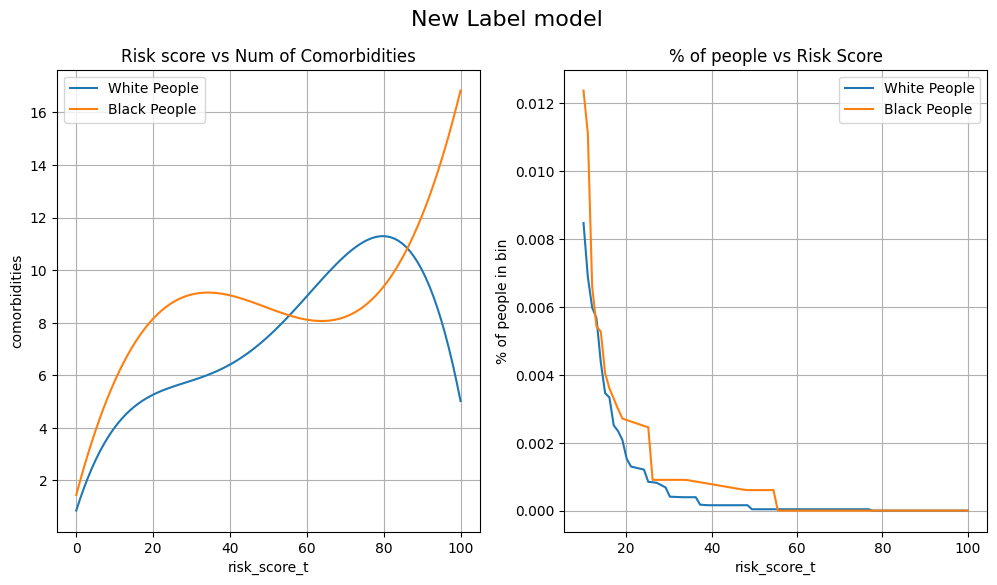

In [24]:
#@title Plot the results
plot_comorbidities(X, 'New Label model')

#ANN

---
The model, taken from 
ZHANG, Brian Hu; LEMOINE, Blake; MITCHELL, Margaret. *Mitigating unwanted biases with adversarial learning.* In: Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society. 2018. p. 335-340.
uses a neural network and an adversary to reduce bias w.r.t. the sensible feature.


In [25]:
#@title Clean the data
# Load the dataset
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv"
df = pd.read_csv(StringIO(requests.get(url).text))

# Extract race feauture
race_mapping = {'white': 0, 'black': 1}
df['race'] = df['race'].map(race_mapping)

race = df['race']
# Substitute NaN values in order to use the data
df.fillna(0, inplace=True)

scaler = MinMaxScaler(feature_range=(0, 100))
scaler.fit(df['risk_score_t'].values.reshape(-1, 1))
df.loc[:,'risk_score_t_scaled'] = scaler.transform(df['risk_score_t'].values.reshape(-1, 1)).astype(int)

scaler = MinMaxScaler()
scaler.fit(df)
df_notscaled = df.copy(deep=True)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

X = df.drop(['cost_t', 'gagne_sum_t', 'cost_avoidable_t','risk_score_t'], axis = 1)
# Extract target variables (y1, y2, y3) from DataFrame
y1 = df['cost_t']
y2 = df['gagne_sum_t']
y3 = df['cost_avoidable_t']
y = df[['cost_t', 'gagne_sum_t', 'cost_avoidable_t']]
y_r = df['risk_score_t']

indices = np.arange(df.shape[0])

X_train, X_val, yr_train, yr_val, race_train, race_val , indices_train, indices_val= train_test_split(X, y_r, race, indices, test_size=0.35, random_state=42)

In [26]:
#@title Modules for the Adversarial NN
import torch
import torch.nn as nn
import torch.optim as optim

# Define the nn architectures for the main task and adversarial task
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


class AdversarialNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdversarialNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out


# Define the training loop
def train(model, adv_model, criterion, adv_criterion, optimizer, adv_optimizer, X_train, y_train, sensitive_train, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    adv_model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    sensitive_train = sensitive_train.to(device)
    for epoch in range(epochs):
        # Forward step for the network
        y_pred = model(X_train).squeeze()
        loss = criterion(y_pred, y_train)

        # Forward step for the adversary
        adv_pred = adv_model(X_train).squeeze()
        adv_loss = adv_criterion(adv_pred, sensitive_train)

        # Total loss is a weighted sum of the main task loss and the adversarial task loss
        total_loss = loss - adv_loss

        # Backward step
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()

        # Backward step for adversarial task
        adv_optimizer.zero_grad()
        adv_loss.backward()
        adv_optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs}, Main Loss: {loss.item():.4f}, Adv Loss: {adv_loss.item():.4f}')

# Create the models and optimizers
input_dim = 157
hidden_dim = 64
output_dim = 1
model = RegressionNN(input_dim, hidden_dim, output_dim)
adv_model = AdversarialNN(input_dim, hidden_dim, 1)
criterion = nn.MSELoss()
adv_criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
adv_optimizer = optim.Adam(adv_model.parameters(), lr=0.001)



In [27]:
#@title Training
epochs = 1000

X_tensor = torch.Tensor(X_train.values)
yr_tensor = torch.Tensor(yr_train.values)
race_tensor = torch.Tensor(race_train.values)
train(model, adv_model, criterion, adv_criterion, optimizer, adv_optimizer, X_tensor, yr_tensor, race_tensor, epochs)

Epoch 0/1000, Main Loss: 0.0043, Adv Loss: 0.7360
Epoch 100/1000, Main Loss: 0.0006, Adv Loss: 0.1688
Epoch 200/1000, Main Loss: 0.0001, Adv Loss: 0.0042
Epoch 300/1000, Main Loss: 0.0000, Adv Loss: 0.0009
Epoch 400/1000, Main Loss: 0.0000, Adv Loss: 0.0004
Epoch 500/1000, Main Loss: 0.0000, Adv Loss: 0.0002
Epoch 600/1000, Main Loss: 0.0000, Adv Loss: 0.0002
Epoch 700/1000, Main Loss: 0.0000, Adv Loss: 0.0001
Epoch 800/1000, Main Loss: 0.0000, Adv Loss: 0.0001
Epoch 900/1000, Main Loss: 0.0000, Adv Loss: 0.0001


In [28]:
#@title Validation loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_val = torch.Tensor(X_val.values).float().to(device)
yr_val = torch.Tensor(yr_val.values).to(device)
 
y_loss = model(X_val)
loss = criterion(y_loss, yr_val)
print('Loss on validation data:', loss)

Loss on validation data: tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17075])) that is different to the input size (torch.Size([17075, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:
#@title Get results

# create a tensor
X_test_tensor = torch.tensor(X_train.values).float().to(device)

# get predictions for the data
y_pred = model(X_test_tensor)

# convert the predictions to a numpy array
y_pred_array = y_pred.cpu().detach().numpy()

<ipython-input-4-df564a953dd6>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot1.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot1['risk_score_t'].values.reshape(-1, 1)).astype(int)
<ipython-input-4-df564a953dd6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2.loc[:,'risk_score_t_scaled'] = scaler.transform(df_plot2['risk_score_t'].values.reshape(-1, 1)).astype(int)


max: 18
*-------------------------------------*
Percentage of White People in the high risk section: 0.75%
Percentage of Black People in the high risk section: 0.25%
*-------------------------------------*

*-------------------------------------*
Num of White People in the high risk section: 9
Num of Black People in the high risk section: 3
*-------------------------------------*

mean: 3.9396702161757897


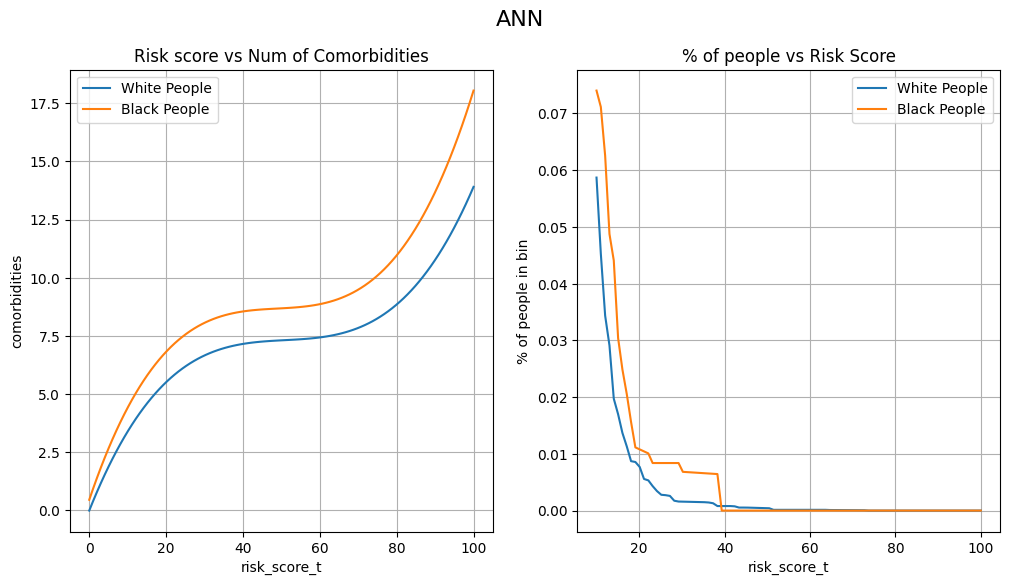

In [30]:
#@title Plot
df_notscaled.loc[indices_train,'risk_score_t'] = y_pred_array
X_toplot = df_notscaled.loc[indices_train,:]
plot_comorbidities(X_toplot , 'ANN')

# Discussion

---
Acknowleging bias in tools that are used to manage the health of people results fundamental to offer a fair and optimal service.

The results show that debiasing a ML model is more tricky than what it seems and static models applicable to all scenarios do not exist. 

Basic libraries implement some tools to detect bias and apply *trasformations* on data but they still have the need to be tuned on the specific instance in order to avoid degrading performances in accuracy; even when tuned some of them do not perform well on the specific problem.

The best way to get rid of bias is to *reformulate the problem* using labels that are less affected by it, then deriving the target ones; finding a new formulation may not be possible only in some specific instances, contrary to what happened above.

Bias evaluations should be carried in any context where data targets humans. 
Some other examples of models where bias arises are:

*   car insurance companies (a 2021 Unipd study that showed how they were affected by bias between people born in diffent areas of Italy)
*   job offering

